## Creating synthetic data


Loading the VERDICT MODEL 
\begin{equation}
 E_{\textrm{VERDICT}}= \underbrace{f_{\textrm{Tumor}}\overbrace{E(D|\lambda_{\textrm{intra}})}^{\textrm{Sphere}}}_{\textrm{Tumor Cells}} + \underbrace{f_{\textrm{extra}}\overbrace{E(\cdot|\lambda_{iso})}^{\textrm{Ball}}}_{\textrm{Hindered Extra-Cellular}}+\underbrace{f_{blood}\overbrace{E(\lambda_\parallel, \boldsymbol{\mu})}^{\textrm{Stick}}}_{\textrm{Vascular}}
\end{equation}

In [203]:
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel, MultiCompartmentSphericalHarmonicsModel
import numpy as np
from scipy.stats import rice
import matplotlib as mpl
import matplotlib.gridspec as gridspec


sphere = sphere_models.S4SphereGaussianPhaseApproximation(diffusion_constant=1.2e-9)
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()

verdict_mod = MultiCompartmentModel(models=[sphere, ball, stick])

verdict_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 2e-9) #2
verdict_mod.set_fixed_parameter('C1Stick_1_lambda_par',8e-9)
verdict_mod.set_fixed_parameter('C1Stick_1_mu',[1.570796326794897,0])


Loading acquisition scheme

In [201]:
from dmipy.core.acquisition_scheme import acquisition_scheme_from_schemefile
from os.path import join

acquisition_path = "/Users/theavage/Documents/Master/Master-Project/data/145.scheme"

scheme= acquisition_scheme_from_schemefile(acquisition_path)

In [202]:
scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 145
number of b0 measurements: 4
number of DWI shells: 46

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |10        |38              |0                        |3.0        |10.0      |80.0 
1           |3         |148             |160                      |3.0        |10.0      |80.0 
2           |3         |231             |200                      |3.0        |10.0      |80.0 
3           |3         |333             |240                      |3.0        |10.0      |80.0 
4           |3         |454             |280                      |3.0        |10.0      |80.0 
5           |3         |593             |320                      |3.0        |10.0      |80.0 
6           |3         |751             |360                      |3.0        |10.0      |80.0 
7           |3         |927             |400                      |3.0        |10.0      |80.0 
8           |3    

## Creating parameter arrays

With random values of R and the IC,EES and VASC volume fractions

In [204]:
def all_comb(ic,ec,vasc,radi):

    comb= []

    for i in ic:
        for j in ec:
            for k in vasc:
                if i+j+k == 1:
                    for r in radi:
                        for l in range(10):
                            comb.append([r,i,j,k])
    return comb

In [205]:
#Creating parameter vector

ranges = np.arange(0.1,1.1,0.1)
ic = ranges; ec = ranges; vasc = ranges
radi = np.arange(2e-6,15e-6,0.5e-6)*2

all_combinations = all_comb(ic,ec,vasc,radi)

#final = fill(all_combinations,4)

parameter_vector = np.array(all_combinations)
parameter_vector.shape

(9180, 4)

(array([1020., 1020.,  680., 1020.,  680., 1020., 1020.,  680., 1020.,
        1020.]),
 array([2.00e-06, 3.30e-06, 4.60e-06, 5.90e-06, 7.20e-06, 8.50e-06,
        9.80e-06, 1.11e-05, 1.24e-05, 1.37e-05, 1.50e-05]),
 <BarContainer object of 10 artists>)

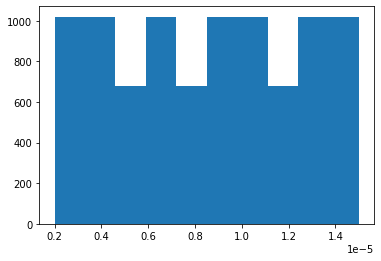

In [57]:
import matplotlib.pyplot as plt
plt.hist(parameter_vector[:,0]/2)

In [118]:
np.sum(parameter_vector[:,1]==0.1)

2160

In [235]:
img = '436_noise_2'

pred_radi = np.load("results/radii_9180_"+img+".npy")
pred_f_sphere = np.load("results/f_sphere_9180_"+img+".npy")
pred_f_ball = np.load("results/f_ball_9180_"+img+".npy")
pred_f_stick = np.load("results/f_stick_9180_"+img+".npy")


In [236]:
from sklearn.metrics import r2_score, mean_absolute_error

print("f_sphere")
print("r2_score: " +str(r2_score(parameter_vector[:,1].flatten(),pred_f_sphere.squeeze())))
print(" mean_absoulte_error: " + str(mean_absolute_error(parameter_vector[:,1].flatten(),pred_f_sphere.squeeze())))

print("f_ball")
print("r2_score: " +str(r2_score(parameter_vector[:,2].flatten(),pred_f_ball.squeeze())))
print(" mean_absoulte_error: " + str(mean_absolute_error(parameter_vector[:,2].flatten(),pred_f_ball.squeeze())))

print("f_stick")
print("r2_score: " +str(r2_score(parameter_vector[:,3].flatten(),pred_f_stick.squeeze())))
print(" mean_absoulte_error: " + str(mean_absolute_error(parameter_vector[:,3].flatten(),pred_f_stick.squeeze())))

print("radi:")
print("r2_score: " + str(r2_score(parameter_vector[:,0].flatten()/parameter_vector[:,0].flatten().max(),pred_radi.squeeze()/pred_radi.squeeze().max())))
print(" mean_absoulte_error: " + str(mean_absolute_error(parameter_vector[:,0].flatten(),pred_radi.squeeze())))



f_sphere
r2_score: 0.9242110857179603
 mean_absoulte_error: 0.03745643164126572
f_ball
r2_score: 0.830227983546179
 mean_absoulte_error: 0.06193453553812435
f_stick
r2_score: 0.9347293653461538
 mean_absoulte_error: 0.04074077369876549
radi:
r2_score: 0.6332637593516055
 mean_absoulte_error: 8.336858324519373


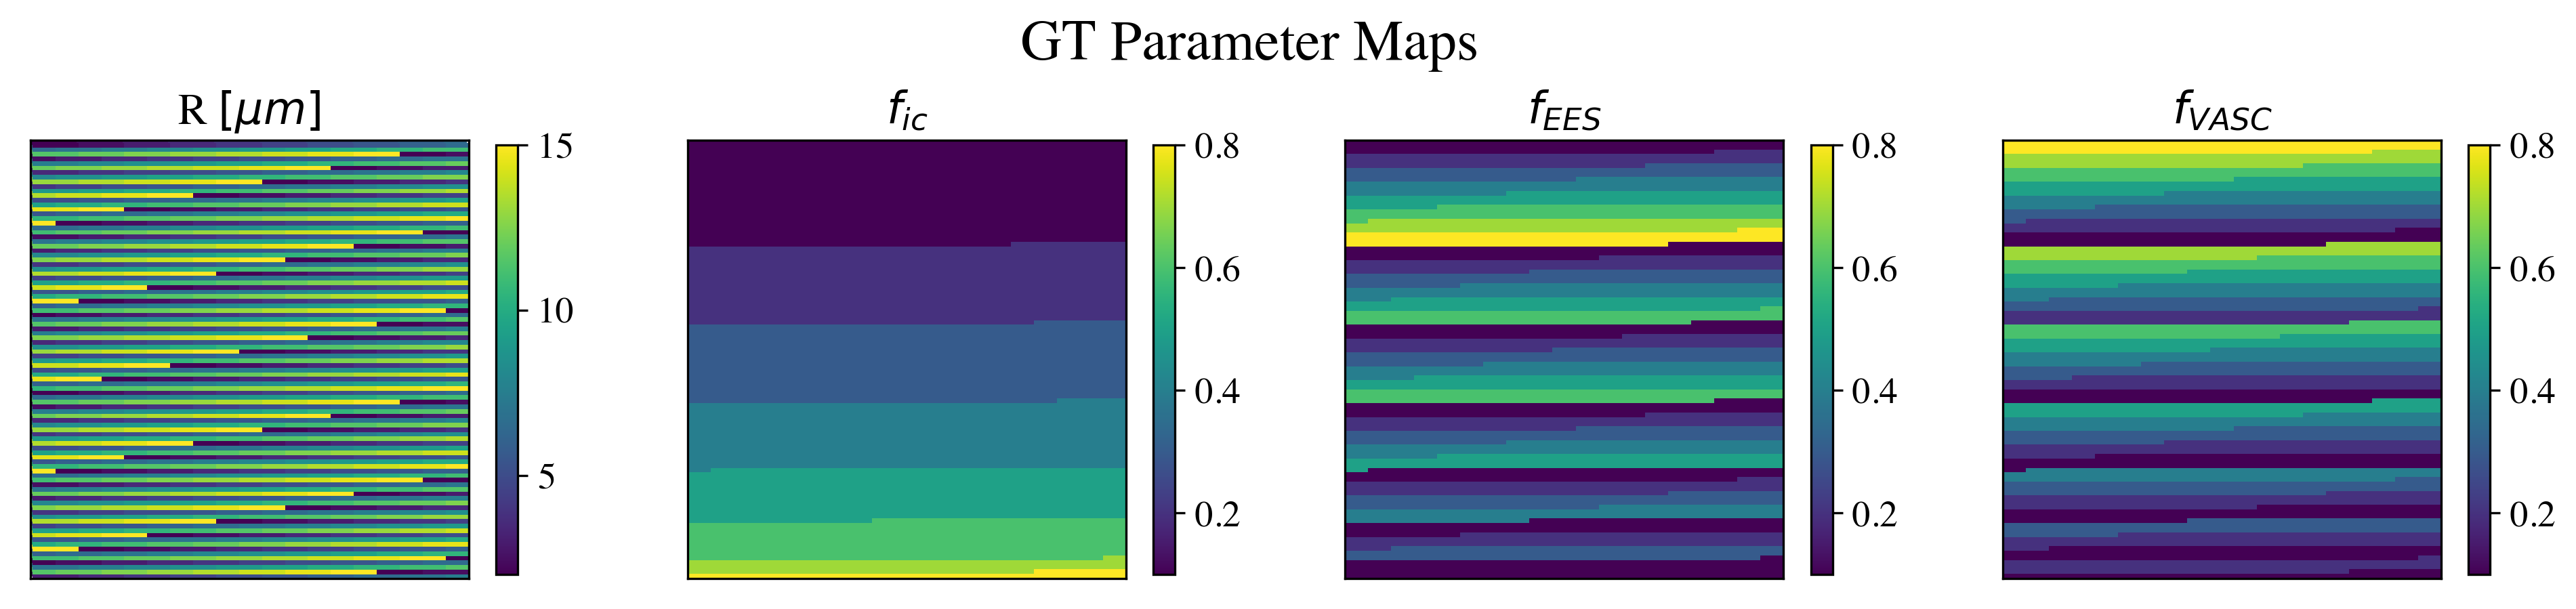

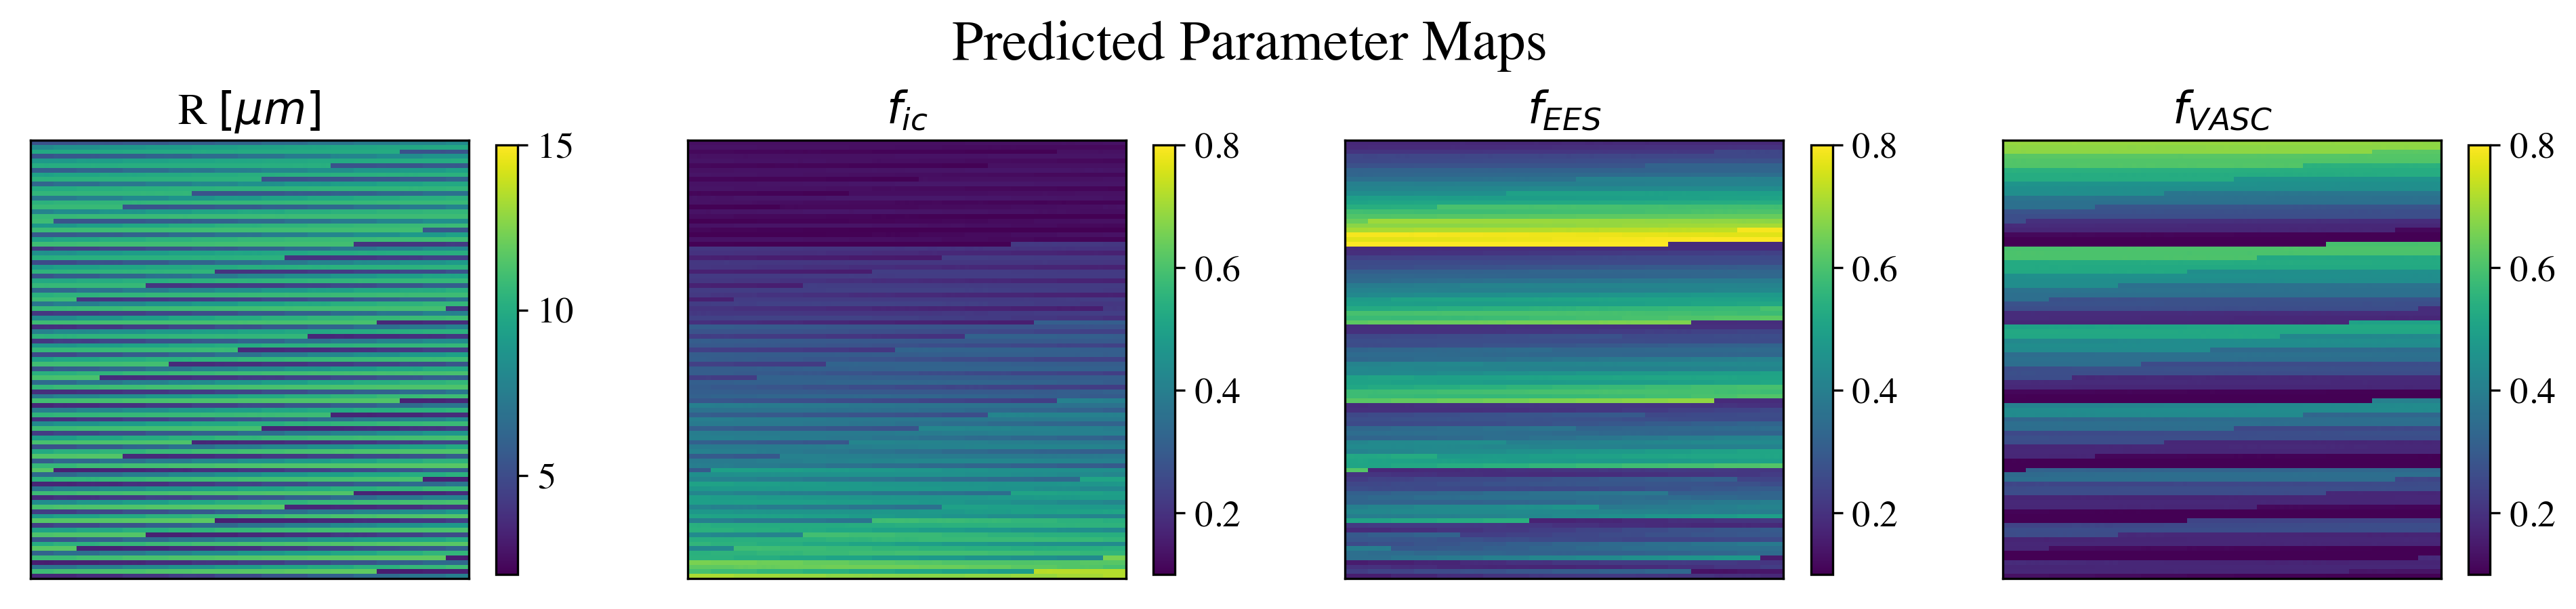

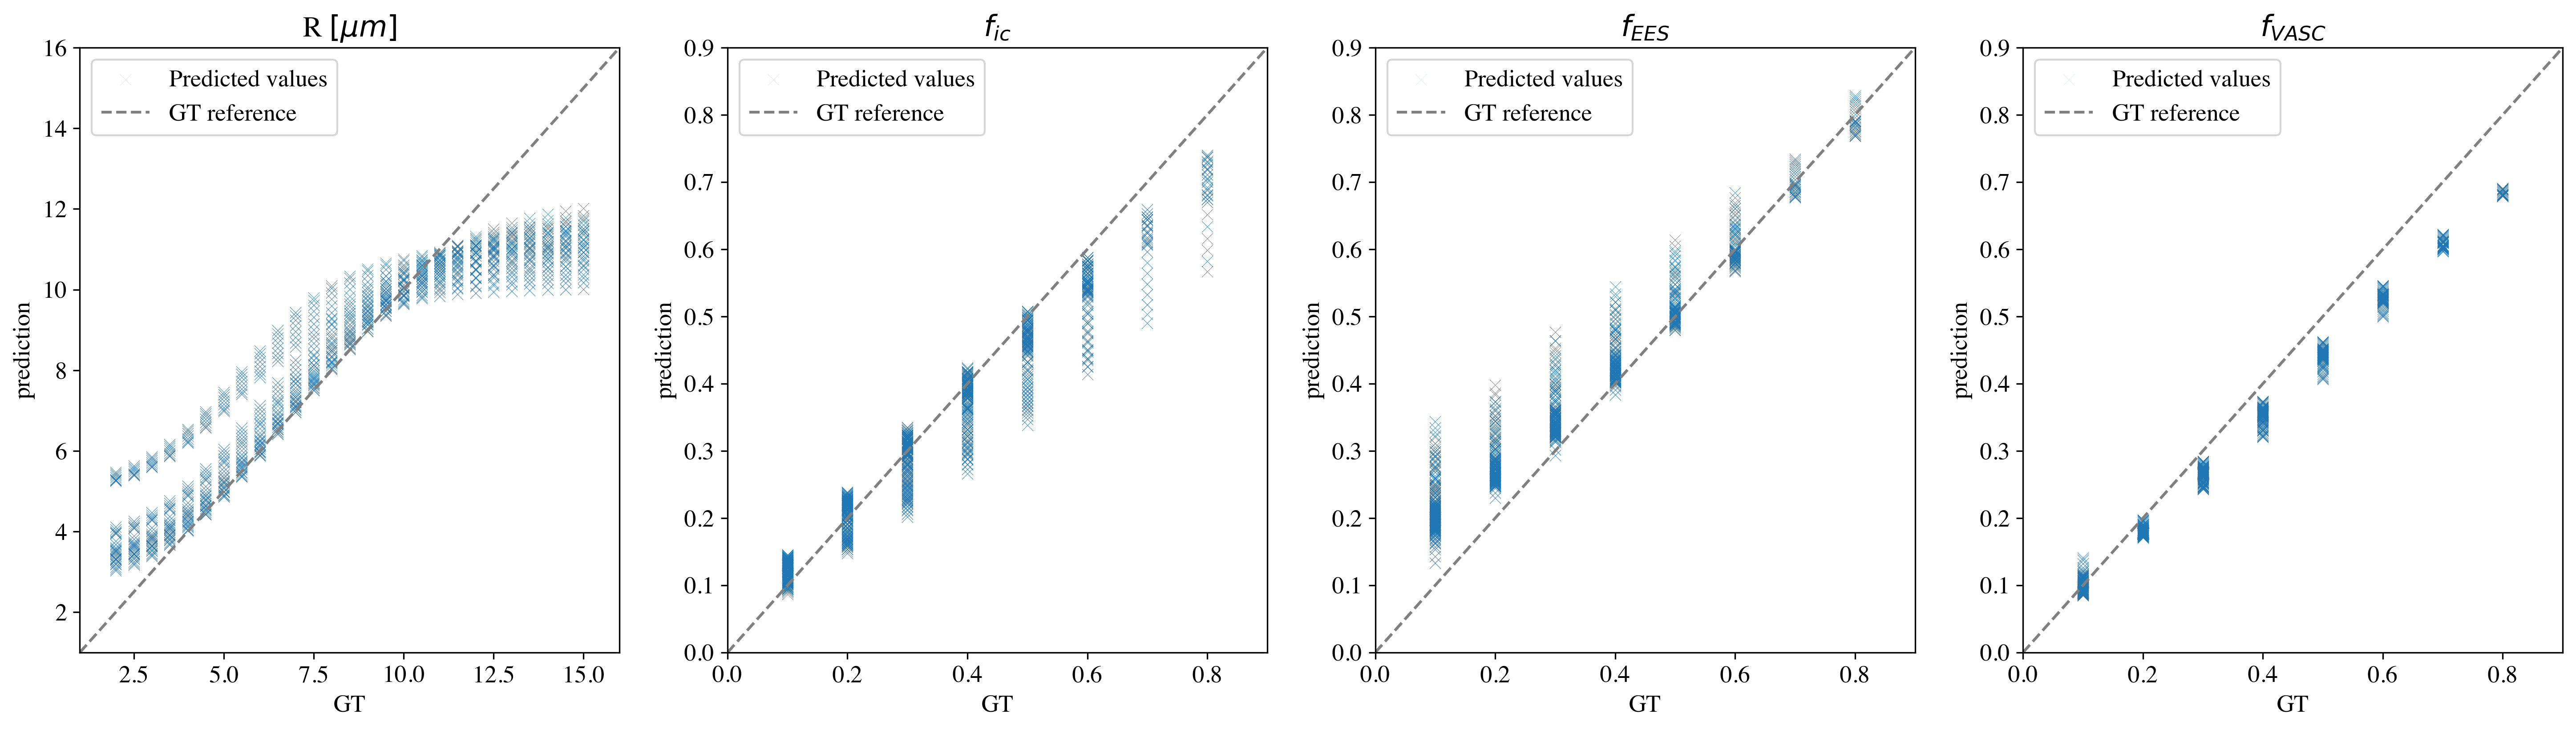

In [237]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numpy import isin
%matplotlib inline

k = 95
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = "times"


fig, ax = plt.subplots(1,4, figsize=(16,3.5))
fig.suptitle('GT Parameter Maps',fontsize=20)

names = ['R $[\mu m]$','$f_{ic}$','$f_{EES}$','$f_{VASC}$']

vis =  parameter_vector[:k*k].reshape(k,k,4)
radi = vis[:,:,0]*1e6/2
image = ax[0].imshow(radi,cmap='viridis')
mesh = ax[0].pcolormesh(radi)
mesh.set_clim(2,15)
fig.colorbar(mesh,ax=ax[0],shrink=0.8)
ax[0].set_title(names[0])
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

for i in [1,2,3]:
    image = ax[i].imshow(vis[:,:,i])
    mappable = image
    mappable.set_clim(0.1, 0.8)
    fig.colorbar(image,ax=ax[i],shrink=0.8)
    ax[i].set_title(names[i])
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

fig, ax = plt.subplots(1,4, figsize=(16,3.5))
fig.suptitle('Predicted Parameter Maps',fontsize=20)

predictions =  [pred_radi,pred_f_sphere,pred_f_ball ,pred_f_stick]

for i in [0,1,2,3]:
    image = ax[i].imshow(predictions[i][:k*k].reshape(k,k))
    mappable = image
    if i == 0:
        mappable.set_clim(2,15)
    else:
        mappable.set_clim(0.1, 0.8)
    fig.colorbar(mappable, ax=ax[i], shrink=0.8)
    ax[i].set_title(names[i])
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)


## Scatter plots
x = np.arange(0,1.1,1/9180)
y = np.arange(0,1.1,1/9180)
x_r = np.arange(1,18,1/9180)
y_r = np.arange(1,18,1/9180)

fig, ax = plt.subplots(1,4, figsize=(24,6))
fig.patch.set_facecolor('white')

plt.rcParams['axes.titlecolor'] = 'black'


for i in range(4):

    if i == 0:
        image = ax[i].scatter(parameter_vector[:,i]*1e6/2,predictions[i],label='Predicted values', marker = 'x', linewidths=0.03)
        ref = ax[i].plot(x_r,y_r, label='GT reference', ls = '--', color = 'gray')
        ax[i].set_xlim(1,16)
        ax[i].set_ylim(1,16)
        ax[i].set_xlabel('GT')
        ax[i].set_ylabel('prediction')
        ax[i].set_title(names[i])
    else:
        image = ax[i].scatter(parameter_vector[:,i],predictions[i],label='Predicted values', marker = 'x', linewidths=0.03)
        ref = ax[i].plot(x,y, label='GT reference',ls = '--', color = 'gray')
        ax[i].set_xlim([parameter_vector[:,i].min()-0.1,parameter_vector[:,i].max()+0.1])
        ax[i].set_ylim([parameter_vector[:,i].min()-0.1,parameter_vector[:,i].max()+0.1])
        ax[i].set_xlabel('GT')
        ax[i].set_ylabel('prediction')
        ax[i].set_title(names[i])

    ax[i].legend()



## Simulating new data from fake parameters
and visualizing 

In [7]:
simulated_signal = verdict_mod.simulate_signal(scheme,parameter_vector)

In [8]:
simulated_signal.shape

(9180, 160)

In [9]:
np.save('simulated_9180_160.npy',simulated_signal)

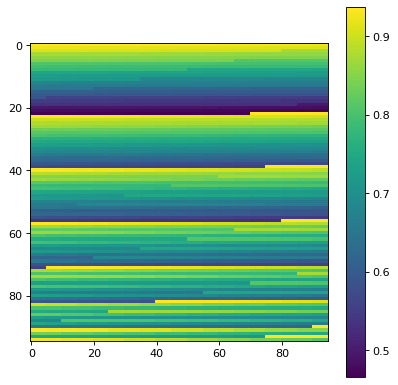

In [15]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,6),dpi=80)
plt.imshow(simulated_signal[:95*95].reshape(95,95,160)[:,:,6])
plt.colorbar()


## Test data

In [243]:
# define parameter values in the three regions
r_region0, r_region1, r_region2 = 10e-6, 20e-6, 30e-6
f_sphere_region0, f_sphere_region1, f_sphere_region2 = 0.2, 0.4, 0.8
f_ball_region0, f_ball_region1, f_ball_region2 = 0.6, 0.2, 0.1
f_stick_region0, f_stick_region1, f_stick_region2 = 0.2, 0.4, 0.1

# image size
sx, sy, sb = 50, 50, len(scheme.bvalues)
# create image
dwi_image = np.zeros((sx, sy, sb))
r_truth = np.zeros((sx, sy))
f_sphere_truth = np.zeros((sx, sy))
f_ball_truth = np.zeros((sx, sy))
f_stick_truth = np.zeros((sx, sy))

# fill image with simulated values
for i in range(sx):
    for j in range(sy):
        if (20 < i < 30) and (20 < j < 30):
            dwi_image[i, j, :] = verdict_mod.simulate_signal(scheme, np.array([r_region0,f_sphere_region0,f_ball_region0,f_stick_region0]))
            r_truth[i, j], f_sphere_truth[i, j], f_ball_truth[i, j], f_stick_truth[i, j] = r_region0, f_sphere_region0, f_ball_region0, f_stick_region0
        elif (10 < i < 40) and (10 < j < 40):
            dwi_image[i, j, :] = verdict_mod.simulate_signal(scheme, np.array([r_region1,f_sphere_region1,f_ball_region1,f_stick_region1]))
            r_truth[i, j], f_sphere_truth[i, j], f_ball_truth[i, j], f_stick_truth[i, j] = r_region1, f_sphere_region1, f_ball_region1, f_stick_region1
        else:
            dwi_image[i, j, :] =verdict_mod.simulate_signal(scheme, np.array([r_region2,f_sphere_region2,f_ball_region2,f_stick_region2]))
            r_truth[i, j], f_sphere_truth[i, j], f_ball_truth[i, j], f_stick_truth[i, j] = r_region2, f_sphere_region2, f_ball_region2, f_stick_region2
# add some noise
#_, dwi_image = rician_noise(dwi_image,scheme.bvalues)


IndexError: index 1400 is out of bounds for axis 2 with size 145

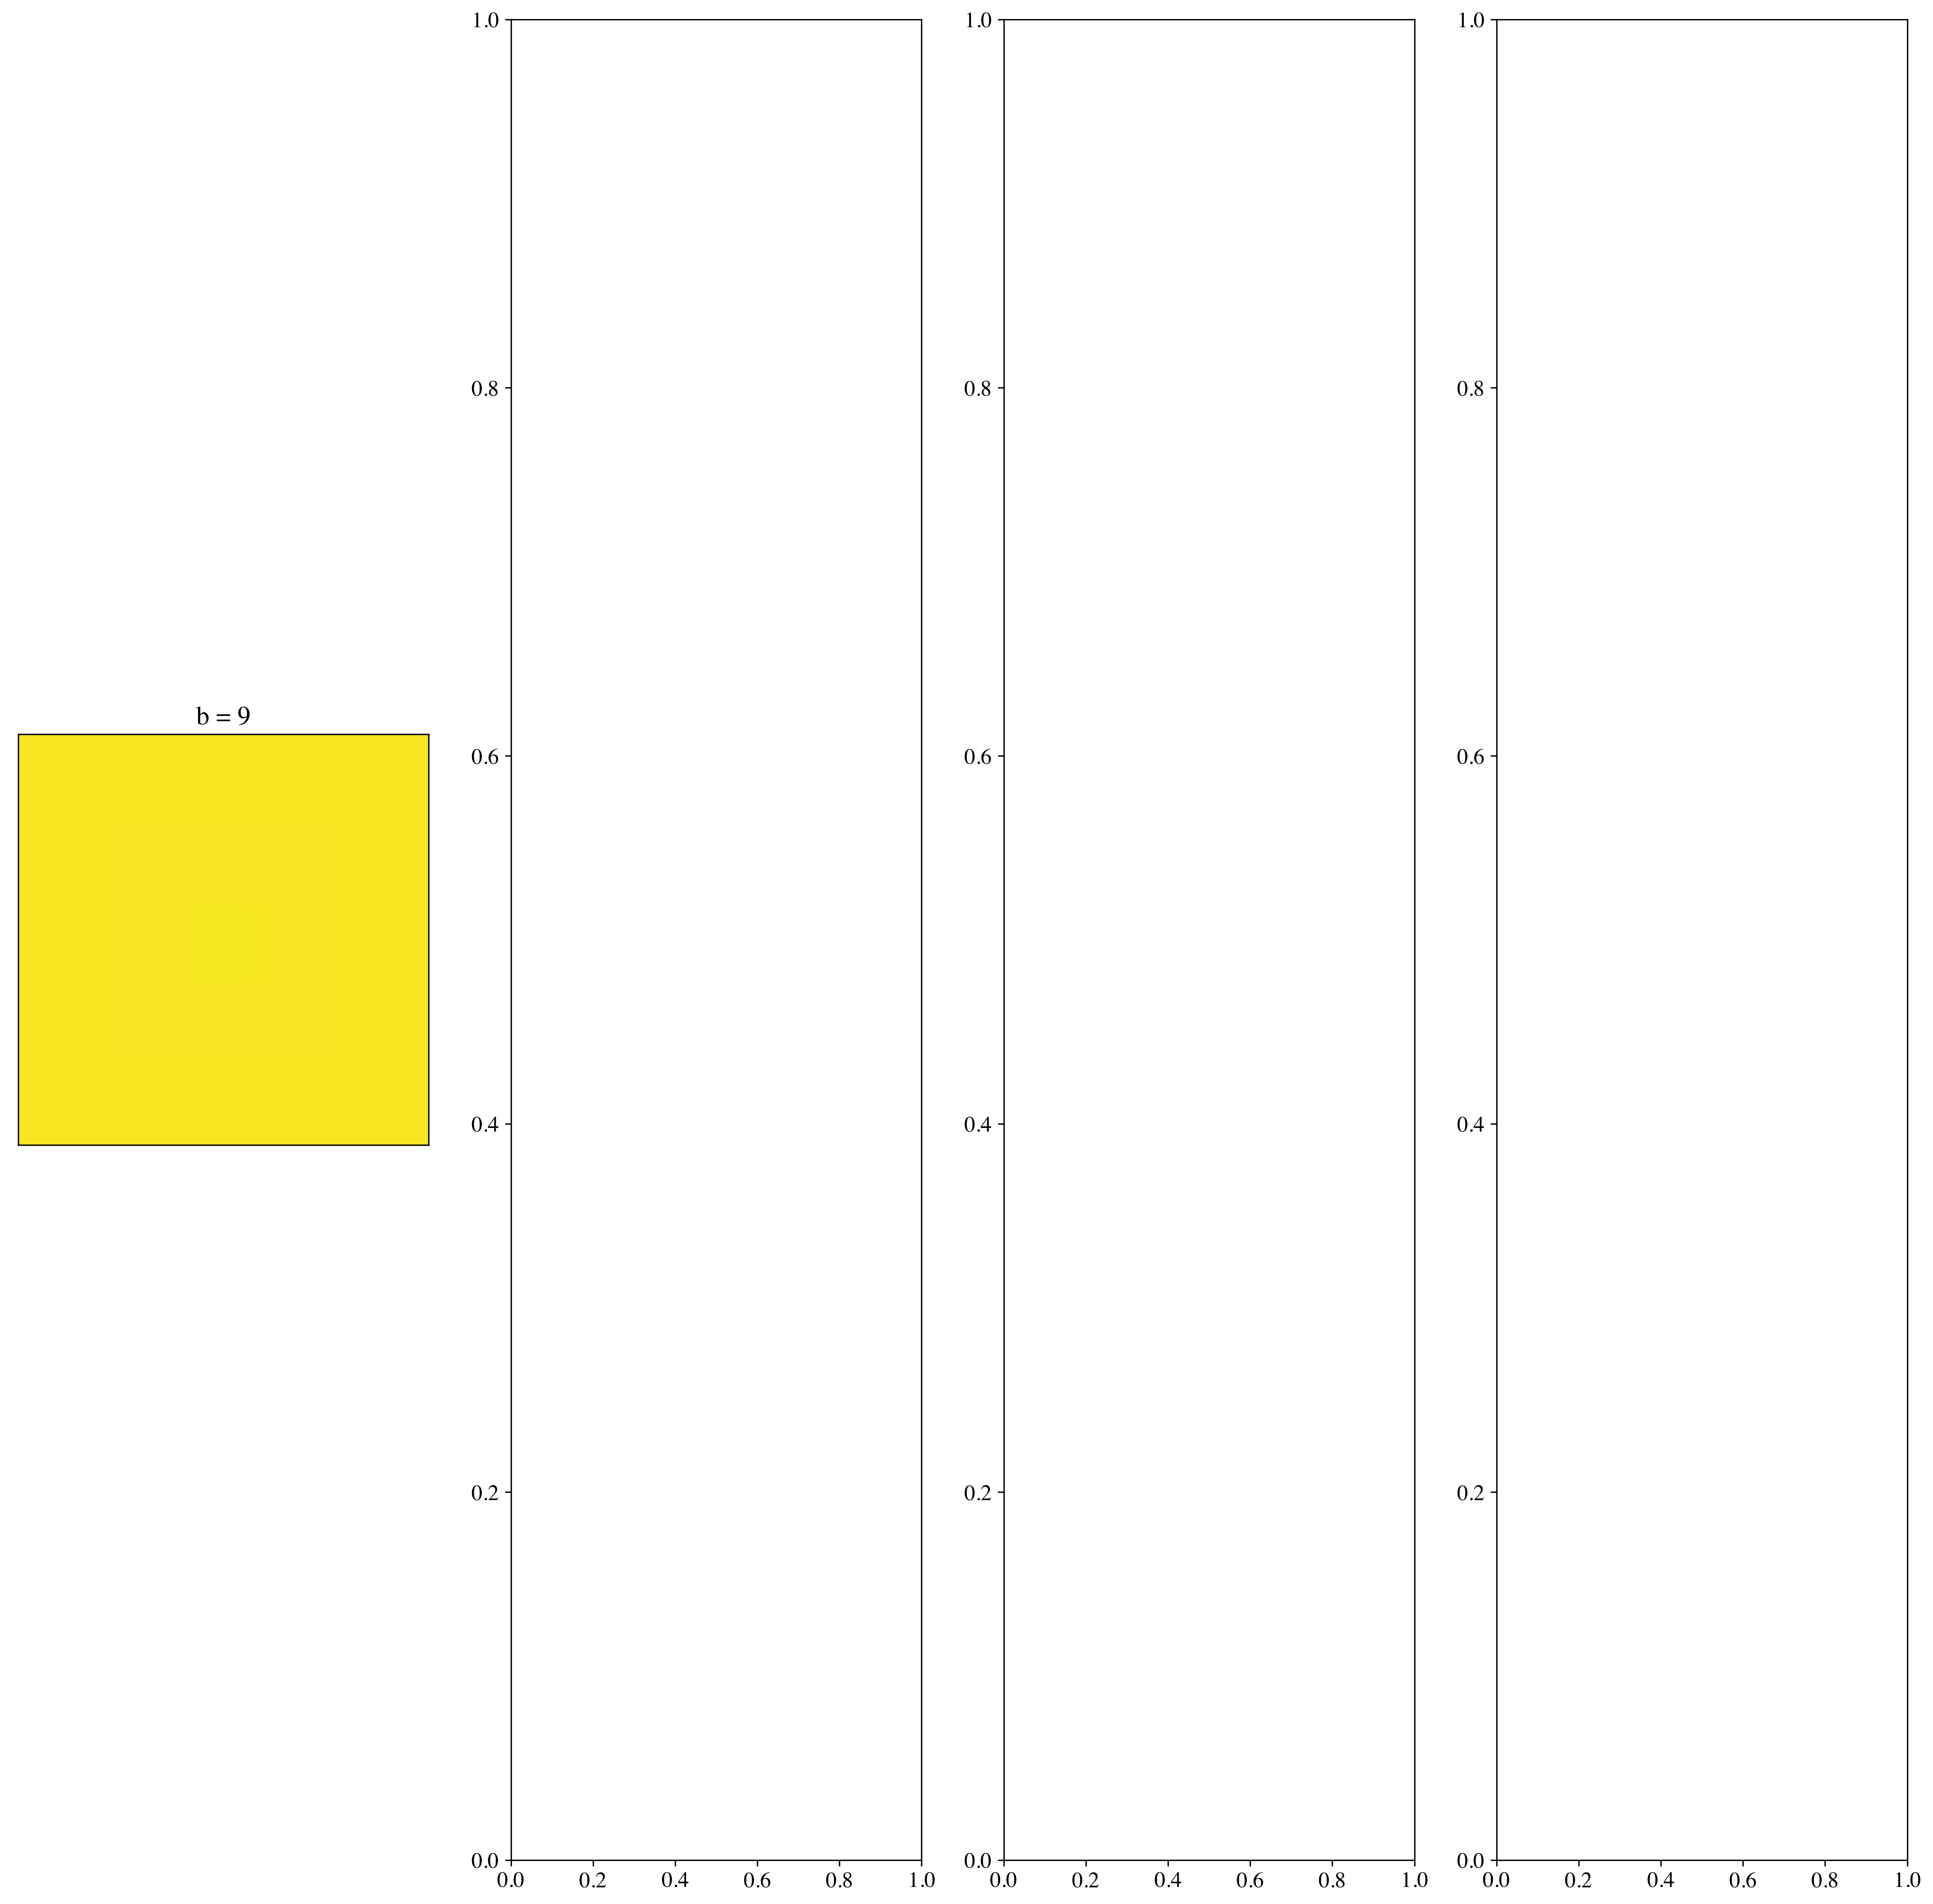

In [244]:
# plot simulated diffusion weighted image
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'times'

b_id = [2,1400,1488,2000] 
fig, ax = plt.subplots(1,len(b_id), figsize=(20,20))
fig.patch.set_facecolor('white')

plt.rcParams['axes.titlecolor'] = 'black'

for i in range(len(b_id)):
    image = ax[i].imshow(dwi_image[:, :, b_id[i]], cmap='viridis', clim=(0, 1))
    ax[i].set_title('b = ' + str(round(scheme.bvalues[b_id[i]]/1e6)))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

cbar_ax = fig.add_axes([0.87, 0.42, 0.02, 0.17])
fig.subplots_adjust(right=0.85)
fig.colorbar(image,cax = cbar_ax)
#mesh = ax[3].pcolormesh(image)
#mesh.set_clim(0,1)
#fig.colorbar(mesh,ax=ax[3],shrink=0.8)


In [238]:
pred_radi = np.load('results/radii_test.npy').reshape(50,50)
pred_f_sphere = np.load('results/f_sphere_test.npy').reshape(50,50)
pred_f_ball = np.load('results/f_ball_test.npy').reshape(50,50)
pred_f_stick = np.load('results/f_stick_test.npy').reshape(50,50)
pred_radi.shape 

(50, 50)

In [239]:

fig, ax = plt.subplots(1,4, figsize=(20,20))
fig.patch.set_facecolor('white')

pred = [pred_radi,pred_f_sphere,pred_f_ball,pred_f_stick]
names = ['R $[\mu m]$','$f_{ic}$','$f_{EES}$','$f_{VASC}$']


plt.rcParams['axes.titlecolor'] = 'black'

for i in range(4):
    image = ax[i].imshow(pred[i], cmap='viridis')
    mappable = image
    if i == 0:
        mappable.set_clim(2,15)
    else:
        mappable.set_clim(0.1, 0.8)
    fig.colorbar(mappable, ax=ax[i], shrink=0.2)
    ax[i].set_title(names[i])
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)


## GT


fig, ax = plt.subplots(1,4, figsize=(20,20))
fig.patch.set_facecolor('white')

gt = [r_truth*1e6/2,f_sphere_truth,f_ball_truth,f_stick_truth]

plt.rcParams['axes.titlecolor'] = 'black'

for i in range(4):
    image = ax[i].imshow(gt[i], cmap='viridis')
    mappable = image
    if i == 0:
        mappable.set_clim(2,15)
    else:
        mappable.set_clim(0.1, 0.8)
    fig.colorbar(mappable, ax=ax[i], shrink=0.2)
    ax[i].set_title(names[i])
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)


## Scatter plots
x = np.arange(0,1.1,1/9180)
y = np.arange(0,1.1,1/9180)
x_r = np.arange(1,18,1/9180)
y_r = np.arange(1,18,1/9180)

fig, ax = plt.subplots(1,4, figsize=(24,6))
fig.patch.set_facecolor('white')

plt.rcParams['axes.titlecolor'] = 'black'


for i in range(4):
    image = ax[i].scatter(gt[i],pred[i],label='Predicted values', marker = 'x', linewidths=3)
    
    if i == 0:
        ref = ax[i].plot(x_r,y_r, label='GT reference', ls = '--', color = 'gray')
        ax[i].set_xlim(1,16)
        ax[i].set_ylim(1,16)
        ax[i].set_xlabel('GT')
        ax[i].set_ylabel('prediction')
        ax[i].set_title(names[i])
    else:

        ref = ax[i].plot(x,y, label='GT reference',ls = '--', color = 'gray')
        ax[i].set_xlim([pred[i].min()-0.1,pred[i].max()+0.1])
        ax[i].set_ylim([pred[i].min()-0.1,pred[i].max()+0.1])
        ax[i].set_xlabel('GT')
        ax[i].set_ylabel('prediction')
        ax[i].set_title(names[i])

    ax[i].legend()

Error in callback <function flush_figures at 0x7fdef0b38310> (for post_execute):


KeyboardInterrupt: 

ValueError: x and y must be the same size

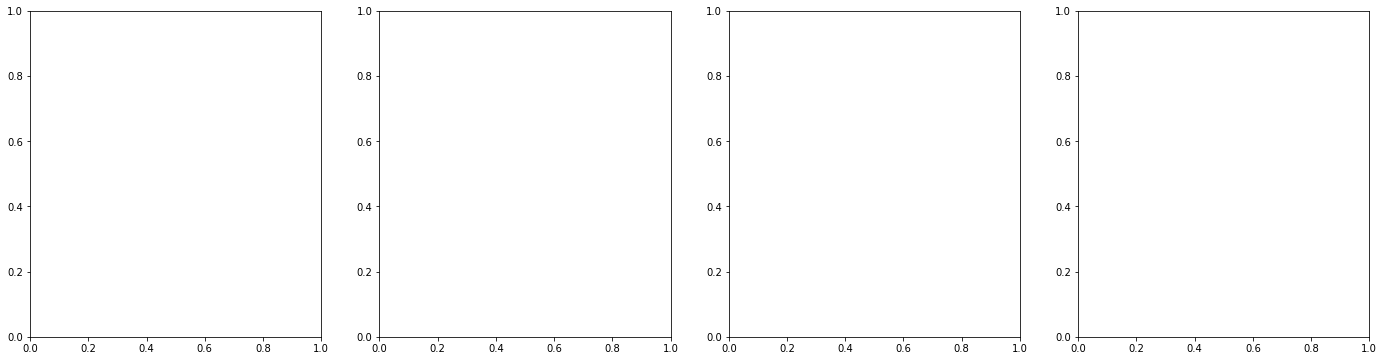

In [55]:


## Scatter plots
x = np.arange(0,1.1,1/1048600)
y = np.arange(0,1.1,1/1048600)
x_r = np.arange(1,18,1/1048600)
y_r = np.arange(1,18,1/1048600)

fig, ax = plt.subplots(1,4, figsize=(24,6))
fig.patch.set_facecolor('white')

plt.rcParams['axes.titlecolor'] = 'black'
pred = [pred_radi,pred_f_sphere,pred_f_ball,pred_f_stick]


for i in range(4):
    image = ax[i].scatter(parameter_vector[:,i],pred[i],label='Predicted values', marker = 'x', linewidths=3)
    
    if i == 0:
        ref = ax[i].plot(x_r,y_r, label='GT reference', ls = '--', color = 'gray')
        ax[i].set_xlim(1,16)
        ax[i].set_ylim(1,16)
        ax[i].set_xlabel('GT')
        ax[i].set_ylabel('prediction')
        ax[i].set_title(names[i])
    else:

        ref = ax[i].plot(x,y, label='GT reference',ls = '--', color = 'gray')
        ax[i].set_xlim([parameter_vector[:,i].min()-0.1,parameter_vector[:,i].max()+0.1])
        ax[i].set_ylim([parameter_vector[:,i].min()-0.1,parameter_vector[:,i].max()+0.1])
        ax[i].set_xlabel('GT')
        ax[i].set_ylabel('prediction')
        ax[i].set_title(names[i])

    ax[i].legend()

In [240]:
from sklearn.metrics import r2_score
print("f_sphere")
print("r2_score: " +str(r2_score(f_sphere_truth.flatten(),pred_f_sphere.flatten())))

print("f_ball")
print("r2_score: " +str(r2_score(f_ball_truth.flatten(),pred_f_ball.flatten())))

print("f_stick")
print("r2_score: " +str(r2_score(f_stick_truth.flatten(),pred_f_stick.flatten())))

print("radi:")
print("r2_score: " + str(r2_score(r_truth/r_truth.max(),pred_radi.squeeze()/pred_radi.squeeze().max())))



f_sphere
r2_score: 0.9945822837132087
f_ball
r2_score: 0.962183256613679
f_stick
r2_score: 0.9992701285950937
radi:
r2_score: 0.9932577339083182


In [17]:
predictions[1]

array([[0.0947611 ],
       [0.0947611 ],
       [0.0947611 ],
       ...,
       [0.78212184],
       [0.78212184],
       [0.78212184]])

In [76]:
f_sphere_truth.min()

0.2

In [82]:
(f_sphere_truth-pred_f_sphere).min()

0.0012203395366668923